In [3]:
!pip install scikeras

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow	import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from scikeras.wrappers import KerasClassifier, KerasRegressor


from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, accuracy_score, f1_score

tf.random.set_seed(42) #for reproducibility of result we always use the same seed for random number generator

# Load Data

In [5]:
df = pd.read_csv('admissions_data.csv')



# Do extensions code below
# if you decide to do the Matplotlib extension, you must save your plot in the directory by uncommenting the line of code below

# fig.savefig('static/images/my_plots.png')

## Clean up column names

In [6]:
df.rename(columns=(lambda x : x.strip().lower()), inplace=True)
df

,serial no.,gre score,toefl score,university rating,sop,lor,cgpa,research,chance of admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...,...
495,496,332,108,5,4.5,4.0,9.02,1,0.87
496,497,337,117,5,5.0,5.0,9.87,1,0.96
497,498,330,120,5,4.5,5.0,9.56,1,0.93
498,499,312,103,4,4.0,5.0,8.43,0,0.73


In [7]:
df['chance of admit'].describe()

count    500.00000
mean       0.72174
std        0.14114
min        0.34000
25%        0.63000
50%        0.72000
75%        0.82000
max        0.97000
Name: chance of admit, dtype: float64

# Visualize Data
Lets look at what relationships the data has. 

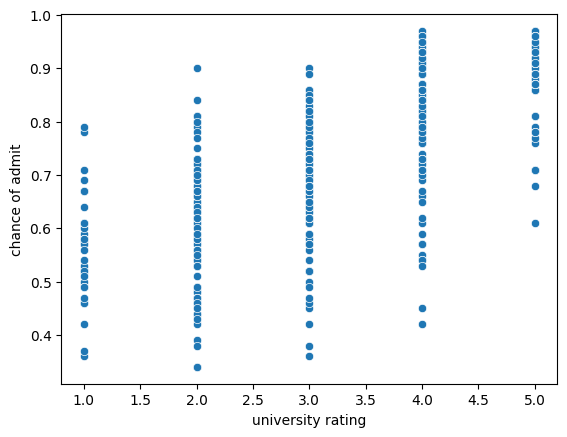

As the university rating gets past 3.5 the chance of admitance goes up. Your best bet at getting admited is to have a university rating of 5.0 


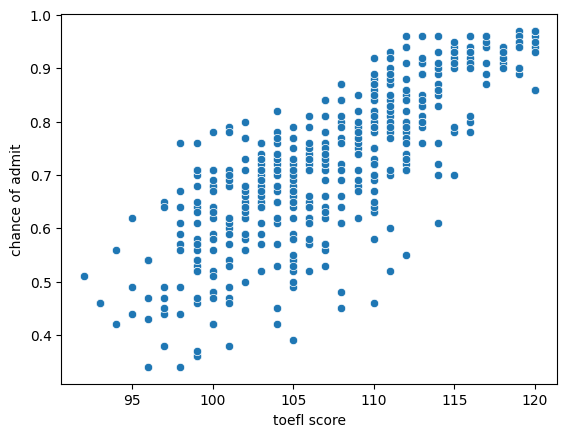

There is a very linear model showing up here. as the toefl score goes up the chance of admitance goes up as well.


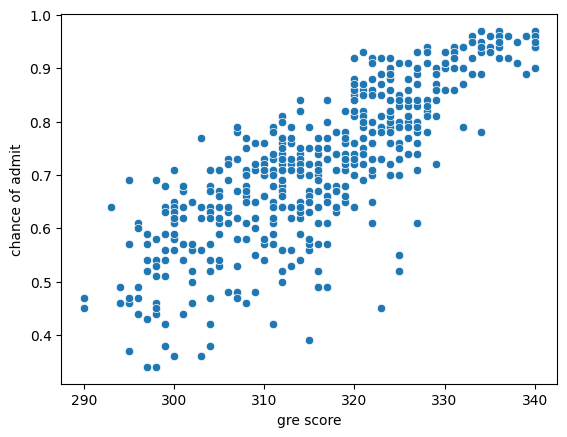

This is a similar to the last graph. as the GRE score goes up the chance of admitance goes up too. 


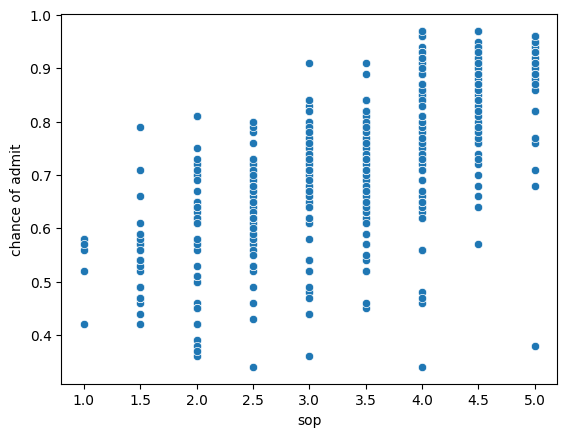

We have a linear model here showing an upward line, but something different here is we have some pretty large outliers. 
These outliners could cause some issues with a prediction model.


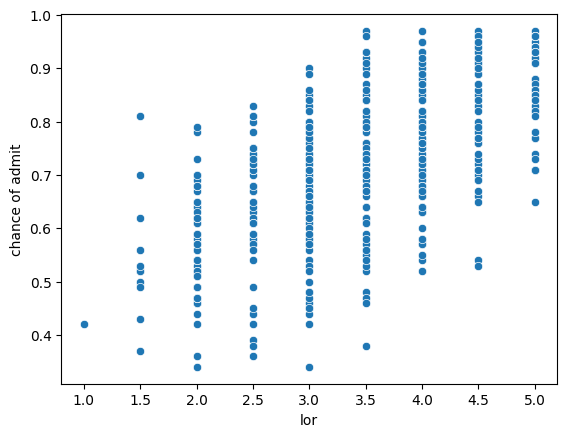

This looks like the sop graph, but it has less outliers in it. It might be more reliable to use in a prediction model.


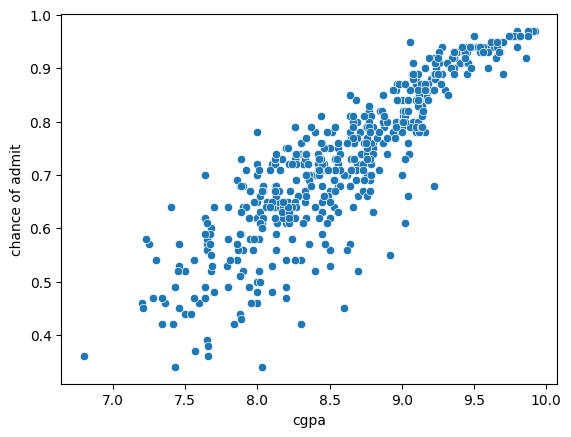

As cgpa goes up we get a very narrow range of admitance. The lower the cgpa the greater the variability in admitance. 


<Figure size 640x480 with 0 Axes>

In [9]:
import seaborn as sns
sns.scatterplot(data= df, x='university rating', y='chance of admit')
plt.show()
plt.clf()
print('As the university rating gets past 3.5 the chance of admitance goes up. Your best bet at getting admited is to have a university rating of 5.0 ')
sns.scatterplot(data= df, x='toefl score', y='chance of admit')
plt.show()
plt.clf()
print('There is a very linear model showing up here. as the toefl score goes up the chance of admitance goes up as well.')
sns.scatterplot(data= df, x='gre score', y='chance of admit')
plt.show()
plt.clf()
print('This is a similar to the last graph. as the GRE score goes up the chance of admitance goes up too. ')
sns.scatterplot(data= df, x='sop', y='chance of admit')
plt.show()
plt.clf()
print('We have a linear model here showing an upward line, but something different here is we have some pretty large outliers. \nThese outliners could cause some issues with a prediction model.')
sns.scatterplot(data= df, x='lor', y='chance of admit')
plt.show()
plt.clf()
print('This looks like the sop graph, but it has less outliers in it. It might be more reliable to use in a prediction model.')
sns.scatterplot(data= df, x='cgpa', y='chance of admit')
plt.show()
plt.clf()
print('As cgpa goes up we get a very narrow range of admitance. The lower the cgpa the greater the variability in admitance. ')

# Clean Features

In [11]:
# clean outliers that will only hinder the performace
df = df[df['chance of admit'] >= .4]
df = df.drop('serial no.', axis=1)
df = df.drop('research', axis=1)

# Create Features and Labels

In [12]:
# create labels and features to train and split
labels = df['chance of admit']
features = df.iloc[:,0:len(df.columns)-1]

# Split Data

In [13]:
#split the data for training and testing
f_train, f_test, l_train, l_test = train_test_split(features, labels, test_size=.2, random_state=21)


# Build Model

In [80]:
learning_rate = 0.01
batch_size = 4
epochs = 200
# using 50 softmax => 50 sigmoid => 50 sigmoid results in the lowest mae/rmse so far
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=f_train.shape[1:])
model = Sequential([
    norm_layer,
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(2, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Fit Model

In [81]:
# create optimizer
opt = tf.keras.optimizers.Adamax(learning_rate = learning_rate)

# set up the metrics for how the model will evaluate performance
model.compile(loss='mse', metrics=['RootMeanSquaredError'], optimizer=opt)

#normalize the training data
norm_layer.adapt(f_train)

# if the model gets a good result stop the model from running and go back to that result
early_stopping = EarlyStopping(monitor='val_root_mean_squared_error', patience=30, restore_best_weights=True)

#fit the model - give it validation data to work with - call earlystopping
history = model.fit(f_train, l_train, epochs= epochs, validation_data=(f_test, l_test), verbose=2, callbacks=[early_stopping])

Epoch 1/200
13/13 - 1s - loss: 0.3065 - root_mean_squared_error: 0.5536 - val_loss: 0.2055 - val_root_mean_squared_error: 0.4533 - 501ms/epoch - 39ms/step
Epoch 2/200
13/13 - 0s - loss: 0.1315 - root_mean_squared_error: 0.3627 - val_loss: 0.0996 - val_root_mean_squared_error: 0.3155 - 78ms/epoch - 6ms/step
Epoch 3/200
13/13 - 0s - loss: 0.0636 - root_mean_squared_error: 0.2521 - val_loss: 0.0648 - val_root_mean_squared_error: 0.2546 - 73ms/epoch - 6ms/step
Epoch 4/200
13/13 - 0s - loss: 0.0449 - root_mean_squared_error: 0.2120 - val_loss: 0.0476 - val_root_mean_squared_error: 0.2181 - 70ms/epoch - 5ms/step
Epoch 5/200
13/13 - 0s - loss: 0.0319 - root_mean_squared_error: 0.1787 - val_loss: 0.0393 - val_root_mean_squared_error: 0.1983 - 69ms/epoch - 5ms/step
Epoch 6/200
13/13 - 0s - loss: 0.0263 - root_mean_squared_error: 0.1623 - val_loss: 0.0340 - val_root_mean_squared_error: 0.1844 - 70ms/epoch - 5ms/step
Epoch 7/200
13/13 - 0s - loss: 0.0224 - root_mean_squared_error: 0.1496 - val_lo

# Evaluate Model

In [425]:
# evaluate the model
mse_test, rmse_test = model.evaluate(f_test, l_test)
mse_train, rmse_train = model.evaluate(f_train, l_train)
# print the models evaluation metrics 
print('MSE score : ', mse_test,'\nRMSE score : ',  rmse_test)
print('------------------------------------------------')
print('Train MSE score : ', mse_train, '\nTrain RMSE score : ', rmse_train)

In [425]:
# get the first 3 test features
x_new = f_test[:3]
# predict answers from those features
y_pred = model.predict(x_new)
# predict the feature test data to look at r2 score
l_pred = model.predict(f_test)
train_pred = model.predict(f_train)
print('----------PREDICTED DATA--------')
print(y_pred)
print('----------TEST DATA---------')
print(l_test[:3])
print('----------R2_Score---------')
print(r2_score(l_test, l_pred))

13/13 [==============================] - 0s 1ms/step - loss: 0.0031 - root_mean_squared_error: 0.0557
MSE score :  0.003356131725013256 
RMSE score :  0.05793213099241257
------------------------------------------------
Train MSE score :  0.003102867631241679 
RMSE score :  0.05570339038968086
13/13 [==============================] - 0s 1ms/step
----------PREDICTED DATA--------
[[0.9615377]
 [0.5865754]
 [0.6231164]]
----------TEST DATA---------
25     0.94
182    0.68
180    0.71
Name: chance of admit, dtype: float64
----------R2_Score---------
0.831321368299106
0.8241266498387756


# Visualize Model

Using different batch #s we can see how they effect the outcome of the model

In [156]:
def design_model(X, learning_rate):  #our function to design the model
    tf.random.set_seed(42)
    norm_layer = tf.keras.layers.Normalization(input_shape=X.shape[1:])
    model = Sequential([
    norm_layer,
    tf.keras.layers.Dense(20, activation='softmax'),
    tf.keras.layers.Dense(20, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='sigmoid'),
    tf.keras.layers.Dense(1)
    ])
    opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(loss='mse', metrics=['RootMeanSquaredError'], optimizer=opt)
    return model


Learning rate fixed to: 0.03


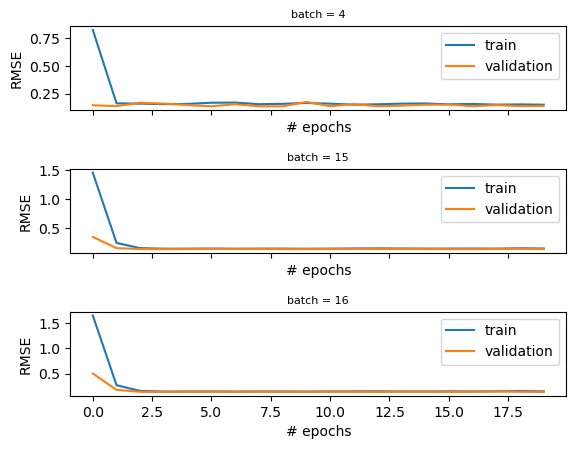

In [281]:
def fit_model(f_train, l_train, learning_rate, num_epochs, batch_size, ax):
    tf.random.set_seed(42)
    model = design_model(f_train, learning_rate)
    #train the model on the training data
    history = model.fit(f_train, l_train, epochs=num_epochs, batch_size = batch_size, verbose=0, validation_data=(f_test, l_test))
    # plot learning curves
    ax.plot(history.history['root_mean_squared_error'], label='train')
    ax.plot(history.history['val_root_mean_squared_error'], label='validation')
    ax.set_title('batch = ' + str(batch_size), fontdict={'fontsize': 8, 'fontweight': 'medium'})
    ax.set_xlabel('# epochs')
    ax.set_ylabel('RMSE')
    ax.legend()

#fixed learning rate 
learning_rate = 0.03
#fixed number of epochs
num_epochs = 20
#we choose a number of batch sizes to try out
# batches = [2, 10, 16] 
batches = [4,15,16]
print("Learning rate fixed to:", learning_rate)

#plotting code
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.7, 'wspace': 0.4}) #preparing axes for plotting
axes = [ax1, ax2, ax3]

#iterate through all the batch values
for i in range(len(batches)):
    fit_model(f_train, l_train, learning_rate, num_epochs, batches[i], axes[i])


The graphs show that 15 batches gives a better result than 4 batches. We can take this back to our original model and see how that effects the MAE, RMSE, and the r2_score. 

# Baseline Median Prediction 

Shows that our model is producing a more 

In [421]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error


dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(f_train, l_train)
y_pred = dummy_regr.predict(f_test)
MAE_baseline = mean_absolute_error(l_test, y_pred)
MSE_baseline = mean_squared_error(l_test, y_pred)
print('Baseline MAE: ', MAE_baseline)

print('MAE from tensorflow model : ', mse_test)
print('RMSE from tensorflow model : ', rmse_test)
print('R2_score from tensorflow model : ', r2_score(l_test, l_pred))

Baseline MAE:  0.11868686868686869
MAE from tensorflow model :  0.00337065733037889
RMSE from tensorflow model :  0.05805736407637596
R2_score from tensorflow model :  0.83059130089403


# Conclusion
 
The small amount of a neural network with small hidden layer neurons gets a better MAE score than just trying to get an accurate prediction by just guessing the median value. while this isnt a perfect model it is much better than guessing. 

A model I will try is a XGboost gradient decent model. 